Dataset Pequeno - https://www.kaggle.com/returnofsputnik/chihuahua-or-muffin

Dataset Grande - https://www.kaggle.com/ingrid2/moffinorchihuahua

In [1]:
!pip install opencv-contrib-python

In [2]:
from os import listdir
from os.path import isfile, join
import numpy as np
import cv2

def load_images_from_folder(folder, gray_scale=False, size=(32,32)):
    imgs = []
    for file in listdir(folder): 
        if isfile(join(folder,file)):
            img = cv2.imread(join(folder, file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if gray_scale else cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            imgs.append(cv2.resize(img, size))
        
    return np.array(imgs)

def load_data(base_path="data/small/", 
              chihuahuas_folder = "chihuahua", 
              muffins_folder = "muffin", 
              gray_scale=False,
             size=(32,32)):
    chihuahuas = load_images_from_folder(join(base_path, chihuahuas_folder), gray_scale, size)
    muffins = load_images_from_folder(join(base_path, muffins_folder), gray_scale, size)
    
    print(f"Carregadas {len(chihuahuas)} imagens de chihuahuas e {len(muffins)} de muffins")
    return {"chihuahuas": chihuahuas, "muffins": muffins}

size = (64,64)
data = load_data(base_path="data/big/",size=size)

Carregadas 279 imagens de chihuahuas e 273 de muffins


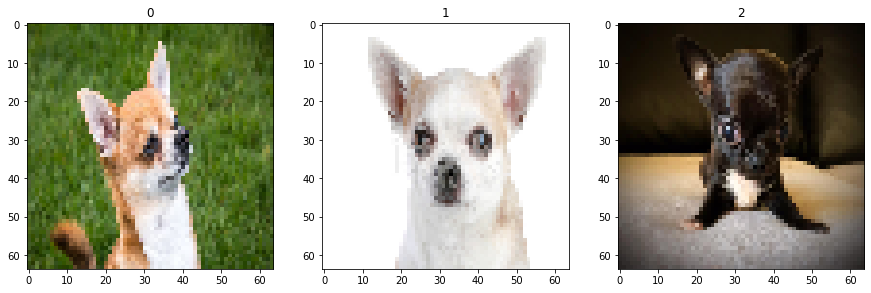

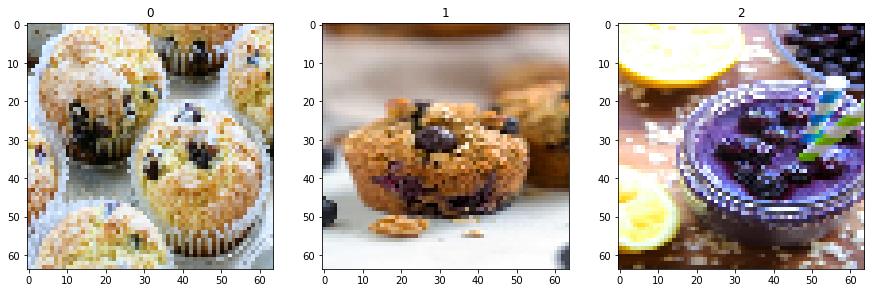

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from math import ceil
def plot_images(images, labels=[], figsize=(15,5), rows=2):
    n = len(images)
    if len(labels) == 0:
        labels = np.arange(n)
    
    columns = ceil(n / rows)
    
    plt.figure(figsize=figsize)
    for i,(img, label) in enumerate(zip(images, labels)):
        plt.subplot(rows, columns, i%columns + 1)
        plt.title(label)
        plt.imshow(img)
    plt.show()
        
plot_images(data["chihuahuas"][:3], rows=1)
plot_images(data["muffins"][:3], rows=1)

In [4]:
def images_to_2d(images):
    return images.reshape(images.shape[0], -1)

def process_data(data):
    X = np.vstack((images_to_2d(data["chihuahuas"]),images_to_2d(data["muffins"])))
    Y = np.array(["chihuahua" for _ in data["chihuahuas"]] + ["muffin" for _ in data["muffins"]])
    
    return X, Y


X,Y = process_data(data)
X.shape, Y.shape

((552, 12288), (552,))

In [5]:
class PPCA():
    
    def __init__(self, n_components = 2):
        self.L = n_components
        
    def log_likelihood(self, X, mean, W, M_inv, sigma, L):
        N,D = X.shape
        s = 0
        for x in X:
            z =  M_inv.dot(W.T).dot((x - mean))

            s += (D/2)*np.log(2*np.pi*sigma) + (L/2)*np.log(2*np.pi) + 0.5*np.trace(np.outer(z,z))
            s += (1/(2*sigma))*np.linalg.norm(x - mean)**2 - (1/sigma)*z.dot(W.T).dot(x-mean)
            s += 1/(2*sigma)*np.trace(np.outer(z,z).dot(W.T).dot(W))

        return -s

    def fit(self, X, W_0 = None, sigma_0=1, iter=10, debug=False):
        N,D = X.shape
        mean = np.mean(X, axis=0)
        
        L = self.L
        W = W_0.copy() if not W_0 is None else np.random.randn(D, L)
        sigma = sigma_0
        M_inv = None

        log_likelihoods = []

        for i in range(iter):
            M_inv = np.linalg.inv(W.T.dot(W) + sigma*np.eye(L))

            e_z = M_inv.dot(W.T).dot((X - mean).T)
            e_zz = sigma*M_inv + e_z.dot(e_z.T)

            W = ((X - mean).T.dot(e_z.T)).dot(np.linalg.inv(e_zz))

            s = 0
            for i,x in enumerate(X):
                e_zi = e_z[:,i]
                e_zzi = sigma*M_inv + np.outer(e_zi, e_zi) 
                s += np.linalg.norm(x-mean)**2 - 2*e_zi.T.dot(W.T).dot(x-mean) + np.trace(e_zzi.dot(W.T).dot(W))

            sigma = s/(N*D)  

            log_likelihoods.append(self.log_likelihood(X, mean, W, M_inv, sigma, L))

            if debug:
                print("\n-----------------------------------\n")
                print(f"Iteração {i+1}")
                print(f"W:\n{W}")
                print(f"Sigma: {sigma}")
                print(f"Log-verossimilhança: {log_likelihoods[-1]}")
        if debug:
            plt.plot(log_likelihoods, label="Log-verossimilhança do treinamento")
            plt.legend()
            plt.show()
        
        self.mean = mean
        self.W = W
        self.sigma = sigma
        self.M_inv = M_inv
        
    def project(self, X):
        return self.M_inv.dot(self.W.T).dot((X - self.mean).T).T
    
    def reconstruct(self, z):
        return self.W.dot(z.T).T + self.mean

In [6]:
ppca = PPCA(100)
ppca.fit(X)

In [7]:
z = ppca.project(X)
x = ppca.reconstruct(z)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


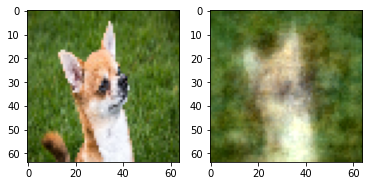

In [8]:
def vector_to_image(x):
    return x.reshape(size[0], size[1], -1)/255

plt.subplot(1,2,1)
plt.imshow(vector_to_image(X[0]))
plt.subplot(1,2,2)
plt.imshow(vector_to_image(x[0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


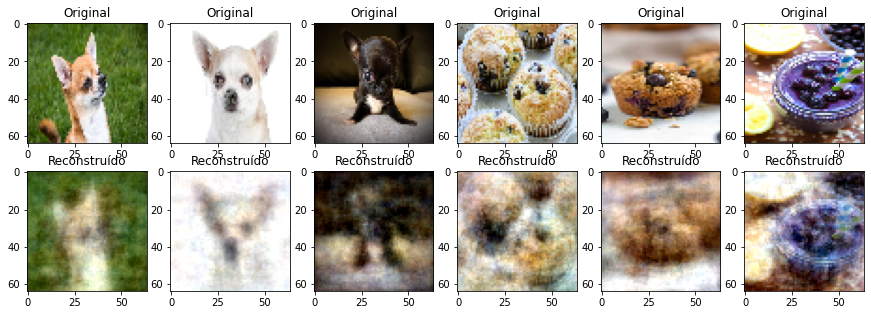

In [9]:
num_samples = 3

chihuahuas = X[Y == "chihuahua"][:num_samples]
muffins = X[Y == "muffin"][:num_samples]

samples = np.vstack((chihuahuas, muffins))
plt.figure(figsize=(15,5))
for n in range(num_samples*2):
    sample = samples[n]
    reconstruct = ppca.reconstruct(ppca.project(sample))
    
    plt.subplot(2, num_samples*2, n+1)
    plt.title("Original")
    plt.imshow(vector_to_image(sample))
    
    plt.subplot(2, num_samples*2, n+num_samples*2+1)
    plt.title("Reconstruído")
    plt.imshow(vector_to_image(reconstruct))
    
plt.show()